In [3]:
%load_ext autoreload
%autoreload 2

In this notebook we ingest as an AXS Catalog the SDSS DR9 Quasar database,  and look for any ZTF observations for these objects.

### Connect to spark

In [4]:
import pyspark
spark = pyspark.sql.SparkSession.builder \
    .config('spark.master', "local[8]")\
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "16g") \
    .config("spark.cores.max", "15") \
    .config("spark.executor.cores", "1") \
    .enableHiveSupport() \
    .getOrCreate()
   

See if everything is OK:

In [3]:
spark

In [4]:
spark.catalog.listTables()

[Table(name='_gatspy_ztf2', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='allwise_1am_dup', database='default', description=None, tableType='EXTERNAL', isTemporary=False),
 Table(name='allwise_500b_28e_10800z', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='asassn_variability_catalog', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='cesium_speedtest_ztfsample', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='cklein_flare', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='dambis_rrlyrae_metalicity', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='demo_result', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='faraway', database='default', description=None, tableType='MANAGED', isTempo

Update 6/11/2019 : now there is ZTF DR1 table `ztf_mar19_all` which contains all light curves for the release...

In [ ]:
spark.catalog.

In [8]:
# To check where these tables physically live, do 
# spark.catalog.listDatabases()

[Database(name='default', description='Default Hive database', locationUri='file:/epyc/projects/lsd2/pzwarehouse')]

How to drop a table : 

In [16]:
axs_catalog.drop_table("ztf_sdss_dr9_qso")

In [17]:
axs_catalog.drop_table("ztf_sdss_dr9_qso2")

### Load AXS catalog with ZTF 

In [5]:
from axs.catalog import AxsCatalog
from axs.axsframe import AxsFrame
axs_catalog = AxsCatalog(spark)
ztf_lc = axs_catalog.load("ztf_mar19_all")# axs_catalog.load("ztf_1am_lc") # ztf light curves .... 

In [10]:
ztf_lc.

{'bucket_col': 'zone',
 'dec_col': 'dec',
 'has_lightcurves': False,
 'lc_columns': JavaObject id=o175,
 'num_buckets': 500,
 'ra_col': 'ra',
 'table_id': 501,
 'table_name': 'ztf_mar19_all',
 'zone_height': 0.0166666666}

In [7]:
ztf_lc.describe()

KeyboardInterrupt: 

Show the top few rows ... 

In [9]:
ztf_lc.head(1)

[Row(matchid=10294422001559, ra=0.029200815384615383, dec=-16.263277997435896, nobs_avail=39, combined_matchids=[10294421013987, 10294421013987, 10294421013987, 10294421013987, 10294421013987, 10294421013987, 10294421013987, 10294421013987, 10294421013987, 10294421013987, 10294421013987, 10294421013987, 10294421013987, 10294421013987, 10294421013987, 10294422001559, 10294422001559, 10294422001559, 10294422001559, 10294422001559, 10294422001559, 10294422001559, 10294422001559, 10294422001559, 10294422001559, 10294422001559, 10294422001559, 10294422001559, 10294422001559, 10294422001559, 10294422001559, 10294422001559, 10294422001559, 10294422001559, 10294422001559, 10294422001559, 10294422001559, 10294422001559, 10294422001559], mjd=[58429.2307176, 58378.3356597, 58426.3169329, 58323.4388194, 58366.3977315, 58338.4080093, 58351.418831, 58345.4153588, 58423.2403356, 58342.436956, 58369.3298611, 58372.4009954, 58432.2429861, 58363.3348495, 58390.3144097, 58360.3542824, 58472.1060532, 5842

So each row is a nested light curve. Cool! 

### Ingest the SDSS S82 DR9 QSO catalog as AXS catalog

Execute the cell below only if `sdss_dr9_qso_s82` was not on the list of spark tables ... 

In [5]:
from astropy.table import Table
from pyspark.sql.types import *

File = 'DB_QSO_S82.dat'
colnames = ['dbID', 'ra', 'dec', 'SDR5ID', 'M_i', 'M_i_corr', 'redshift',
                   'mass_BH', 'Lbol', 'u', 'g', 'r', 'i', 'z', 'Au']
table = Table.read(File, format='ascii', names = colnames)
# make pandas df 
df = table.to_pandas()

# make spark df 
fields = ['dbID', 'ra', 'dec', 'SDR5ID', 'M_i', 'M_i_corr', 'redshift',
                   'mass_BH', 'Lbol', 'u', 'g', 'r', 'i', 'z', 'Au']

field_types = [IntegerType(),DoubleType(),DoubleType(),IntegerType(),
               DoubleType(),DoubleType(),DoubleType(),DoubleType(),DoubleType(),
               DoubleType(),DoubleType(),DoubleType(),DoubleType(),DoubleType(),
               DoubleType()]

fields = [StructField(field_name, type_class, True) for field_name, 
          type_class in zip(fields, field_types)]
schema = StructType(fields)
sdf = spark.createDataFrame(df,schema=schema)

In [8]:
from axs import Constants
axs_catalog.save_axs_table(sdf,"sdss_dr9_qso_s82",  True, True, 500 ,Constants.ONE_AMIN)

Since the steps above have been done,  I can read in the results : 

In [11]:
qso = axs_catalog.load("sdss_dr9_qso_s82")

In [11]:
qso.head(1)

[Row(dbID=133470, ra=0.237056, dec=-1.069386, SDR5ID=40, M_i=-26.287, M_i_corr=-26.913, redshift=2.1065, mass_BH=0.0, Lbol=0.0, u=20.502, g=20.186, r=19.632, i=19.279, z=18.842, Au=0.213, zone=5335, dup=0)]

### Steps to crossmatch ZTF matchfiles (LC) to SDSS S82  DB9 QSO

S82 is a narrow strip in dec. Illustrate the extent :

Text(0, 0.5, 'dec')

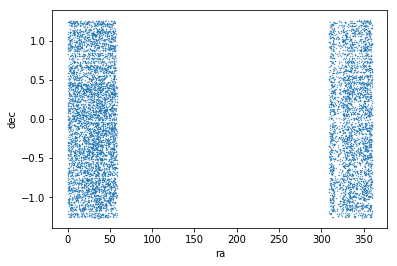

In [12]:
# Illustrate the extent of S82 : 
# it's a narrow strip in dec 
table = qso.select(['ra','dec']).limit(10000).toPandas()

%matplotlib inline
import matplotlib.pyplot as plt 
plt.scatter(table['ra'], table['dec'], s=0.1)
plt.xlabel('ra')
plt.ylabel('dec')

To speed up the process, we limit the range of ZTF to ra,dec covered by S82 : $\|{ \delta }\| < 1.3$. Also,  select ZTF light curves that have more than 1 good epoch : 

In [13]:
ztf_lc.columns

['matchid',
 'ra',
 'dec',
 'nobs_avail',
 'combined_matchids',
 'mjd',
 'programid',
 'filterid',
 'mag',
 'magerr',
 'psfmag',
 'psfmagerr',
 'psfflux',
 'psffluxerr',
 'chi',
 'catflags',
 'sharp',
 'xpos',
 'ypos',
 'zone',
 'dup']

In [13]:
from pyspark.sql.functions import abs as sparkabs  # need to use the spark abs 

ztf_lc_select = ztf_lc.select(['zone', 'dup', 'matchid', 'ra', 'dec', 
              'mag', 'magerr', 'psfmag','psfmagerr', 'filterid', 'mjd','nobs_avail']).\
     where((ztf_lc['nobs_avail']>1) & (sparkabs(ztf_lc['dec']) < 1.3) )
                               
#ztf_lc_select = ztf_lc.select(['zone', 'dup', 'matchid', 'ra', 'dec', 
#               'bestmagrms', 'bestmeanmag', 'bestmedianmag',
#               'medianmag','meanmag','nbestobs', 'ngoodobs']).\
#      where((ztf_lc['ngoodobs']>1) & (sparkabs(ztf_lc['dec']) < 1.3) )

Show how many rows this selection includes... 

In [15]:
%%time 
ztf_lc_select.count()

CPU times: user 28.3 ms, sys: 9.51 ms, total: 37.8 ms
Wall time: 3min 10s


30638696

Perform the crossmatch:

( before the  crossmatch I had to remove the existing catalog because the connection stalled during the crossmatch ...) . `axs_catalog.drop_table()` wouldn't work because it didn't get fully ingested to axis. Needed to manually remove the temporary files. This was done by :

    ssh suberlak@epyc.astro.washington.edu  
    cd /epyc/projects/lsd2/pzwarehouse/
    rm -rf ztf_dr1_s82_qso/
    exit 
    

In [18]:
%%time
from axs import Constants
fname = "ztf_dr1_s82_qso"
crossmatch = ztf_lc_select.crossmatch(qso, r=2*Constants.ONE_ASEC).\
    save_axs_table(fname)

CPU times: user 2.72 s, sys: 984 ms, total: 3.7 s
Wall time: 3h 43min 58s


In [5]:
# If all the above has already been executed, just 
# load the AXS catalog, move to pandas, to astropy,
# and save as a text file to export locally and compare to SDSS, PS1 data ... 
from axs.catalog import AxsCatalog
axs_catalog = AxsCatalog(spark)
zq = axs_catalog.load("ztf_dr1_s82_qso")
zqt = zq.toPandas()


In [6]:
from astropy.table import Table
zqt1 = Table.from_pandas(zqt)

In [12]:
zqt1.write('ztf_dr1_s82_qso_lcs.tbl', format='ipac')


I scp that to my local machine :
    
    cd ~/GradResearch/Paper2_SDSS_PTF_PS1/raw_data/
    scp suberlak@epyc.astro.washington.edu:/epyc/users/suberlak/ztf_dr1_s82_qso_lcs.tbl .
        
I can read it in with 
       
    from astropy.table import Table
    ztf = Table.read('ztf_dr1_s82_qso_lcs.tbl', format='ipac')

( Before ZTF DR1 the problem was : no actual overlap ... ) 

In [8]:
t = ztf_lc_select.toPandas()

In [10]:
t[:5]

,zone,dup,matchid,ra,dec,bestmagrms,bestmeanmag,bestmedianmag,medianmag,meanmag,nbestobs,ngoodobs
0,5335,0,0004241202216748,195.684502,-1.077257,0.104484,20.637121,20.637121,20.637121,20.637121,2,2
1,5335,0,0004241202206664,195.688365,-1.068434,0.021098,16.971289,16.977032,16.976179,16.970150,21,24
2,5335,0,0004241202201518,195.690204,-1.079686,0.109264,19.722658,19.702240,19.714390,19.731030,19,21
3,5335,1,0004241202206655,195.692898,-1.066118,0.166418,19.209494,19.247002,19.246765,19.214813,19,22
4,5335,0,0004241202201469,195.706372,-1.071385,0.186656,20.317308,20.231001,20.260391,20.315016,11,12


In [9]:
from astropy.table import Table

File = 'DB_QSO_S82.dat'
colnames = ['dbID', 'ra', 'dec', 'SDR5ID', 'M_i', 'M_i_corr', 'redshift',
                   'mass_BH', 'Lbol', 'u', 'g', 'r', 'i', 'z', 'Au']
dbqso = Table.read(File, format='ascii', names = colnames)

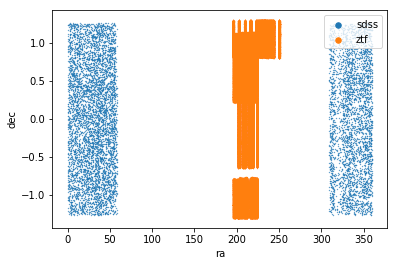

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt 
plt.scatter(dbqso['ra'], dbqso['dec'], s=0.1, label='sdss')
plt.scatter(t['ra'], t['dec'], s=0.01, label='ztf')
plt.xlabel('ra')
plt.ylabel('dec')
lgnd = plt.legend()
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
plt.savefig('ztf_1am_lc_vs_sdss_dr9_qso_s82_190301.png', bbox_inches='tight', dpi=150)

In [ ]:
pwd